In [19]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO, UNO, TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore, LpLoss_energy
from models import UNO_reparam, TFNO_reparam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Subsampling rate
ntrain = 1500
ntest = 150
batch_size = 32

t1 = 5
t2 = 6
data = np.load("data/ks_2d_data.npy").astype(np.float32)

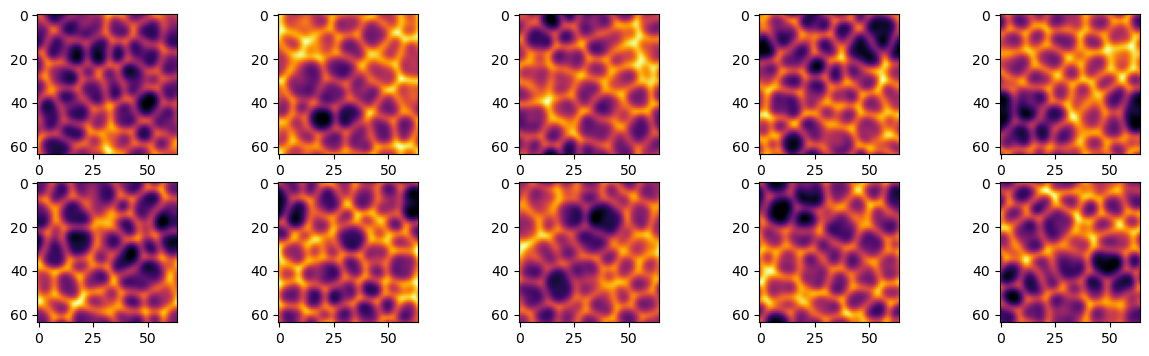

In [21]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(2, 5, figsize = (15,4))
index = 0
for i, sample in enumerate(n_samples):
    axs[0,i].imshow(data[sample, t1], cmap = "inferno")
    axs[1,i].imshow(data[sample, t2], cmap = "inferno")

In [22]:
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain], y_data[:ntrain]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
x = np.linspace(0, grid_range, size_x)
y = np.linspace(0, grid_range, size_x)
gridx = np.stack(np.meshgrid(x, y))
gridx = torch.tensor(gridx).float().reshape(1, 2, size_x, size_x)

x_train = torch.cat((x_train, gridx.repeat([ntrain, 1, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx.repeat([ntest, 1, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [23]:
# Losses and parameters
l2loss = LpLoss(d=2, p=2, L = 50.0)
energy_score = EnergyScore(d = 2, p = 2, type = "lp", L = 50.0)

# Training parameters
epochs = 25
learning_rate = 0.0015
dropout_rate = 0.1

# MC dropout

In [24]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [25]:
model = TFNO(n_modes=(16,16), hidden_channels=32, projection_channels=64,in_channels = 3, rank = 0.42, use_mlp = True, mlp_dropout=dropout_rate)

model = UNO(in_channels =3,out_channels = 1, hidden_channels=32, projection_channels=64,uno_out_channels = [32,64,64,32],
            uno_n_modes= [[16,16],[16,16],[16,16],[16,16]], uno_scalings=  [[1.0,1.0],[0.5,0.5],[2,2],[1,1]],
            horizontal_skips_map = None, n_layers = 4, domain_padding = 0.2, factorization = "tucker", rank = 0.6)

model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 2558369 parameters.


In [26]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [27]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-2.8882, Train-MSE-0.8938, Train-L2-0.0296, Test-L2-0.0316
Epoch-1, Time-2.8578, Train-MSE-0.8678, Train-L2-0.0292, Test-L2-0.0315
Epoch-2, Time-2.8579, Train-MSE-0.8598, Train-L2-0.0291, Test-L2-0.0315
Epoch-3, Time-2.8595, Train-MSE-0.8637, Train-L2-0.0291, Test-L2-0.0316
Epoch-4, Time-2.8568, Train-MSE-0.8580, Train-L2-0.0290, Test-L2-0.0314
Epoch-5, Time-2.8610, Train-MSE-0.8585, Train-L2-0.0290, Test-L2-0.0315
Epoch-6, Time-2.8577, Train-MSE-0.8600, Train-L2-0.0291, Test-L2-0.0314
Epoch-7, Time-2.8671, Train-MSE-0.8560, Train-L2-0.0290, Test-L2-0.0313
Epoch-8, Time-2.8668, Train-MSE-0.8547, Train-L2-0.0290, Test-L2-0.0316
Epoch-9, Time-2.8680, Train-MSE-0.8549, Train-L2-0.0290, Test-L2-0.0314
Epoch-10, Time-2.8664, Train-MSE-0.8481, Train-L2-0.0289, Test-L2-0.0314
Epoch-11, Time-2.8697, Train-MSE-0.8477, Train-L2-0.0289, Test-L2-0.0314
Epoch-12, Time-2.8674, Train-MSE-0.8425, Train-L2-0.0288, Test-L2-0.0315
Epoch-13, Time-2.8687, Train-MSE-0.8390, Train-L2-0.0287, Tes

In [28]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=50)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x, size_x), y_test.view(-1, size_x, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.9200541377067566
ES: 47.75830841064453


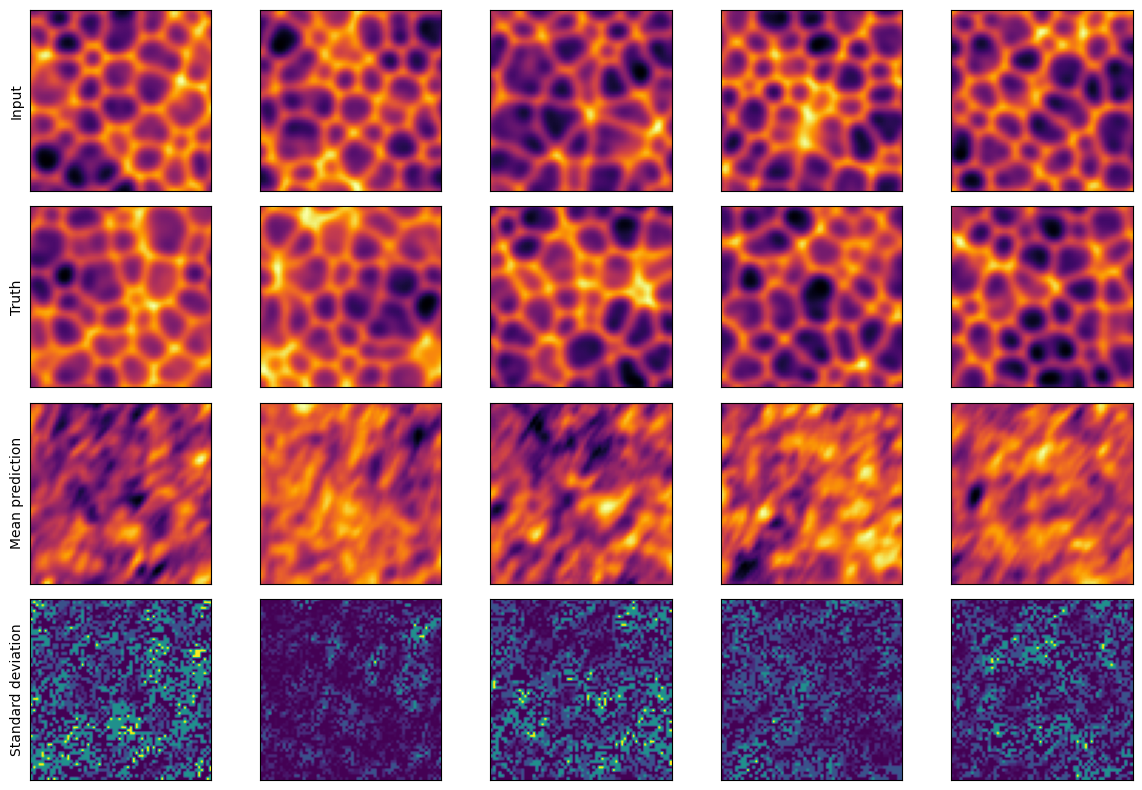

In [29]:
x_test, y_test = test_data

n_samples = np.random.randint(0,ntest,5)

""" Plotting """ 
fig, axs = plt.subplots(4, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(n_samples):
        axs[0,i].imshow(x_test[sample,0].cpu().numpy(), cmap = "inferno")
        axs[1,i].imshow(y_test[sample,0].cpu().numpy(), cmap = "inferno")
        axs[2,i].imshow(pred[sample,0].cpu().numpy().mean(axis = -1), cmap = "inferno")
        axs[3,i].imshow(pred[sample,0].cpu().numpy().std(axis = -1), cmap = "viridis")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')

fig.tight_layout()

In [30]:
pred[:,0].cpu().numpy().std(axis = -1).mean()

1.4926163e-08

# PFNO

In [31]:
sample_model = TFNO_reparam(n_modes=(16,16), hidden_channels=32, projection_channels=64, in_channels=3, n_samples = 5, rank = 0.42,
                            use_mlp = True, mlp_dropout=0)

sample_model = UNO_reparam(in_channels =3,out_channels = 1, hidden_channels=32, projection_channels=64,n_samples = 5,uno_out_channels = [32,64,64,32],
            uno_n_modes= [[16,16],[16,16],[16,16],[16,16]], uno_scalings=  [[1.0,1.0],[0.5,0.5],[2,2],[1,1]],
            horizontal_skips_map = None, n_layers = 4, domain_padding = 0.2, factorization = "tucker", rank = 0.6)

sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [32]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y = sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-3.1952, Train-L2-1.0556, Test-L2-1.1324
Epoch-1, Time-3.1940, Train-L2-1.0288, Test-L2-1.1059
Epoch-2, Time-3.1932, Train-L2-1.0256, Test-L2-1.1075
Epoch-3, Time-3.1928, Train-L2-1.0260, Test-L2-1.1037
Epoch-4, Time-3.1945, Train-L2-1.0238, Test-L2-1.1024
Epoch-5, Time-3.2008, Train-L2-1.0245, Test-L2-1.1076
Epoch-6, Time-3.1942, Train-L2-1.0226, Test-L2-1.1051
Epoch-7, Time-3.1930, Train-L2-1.0237, Test-L2-1.1089
Epoch-8, Time-3.1925, Train-L2-1.0210, Test-L2-1.1079
Epoch-9, Time-3.1933, Train-L2-1.0198, Test-L2-1.1074
Epoch-10, Time-3.1959, Train-L2-1.0168, Test-L2-1.1083
Epoch-11, Time-3.1915, Train-L2-1.0145, Test-L2-1.1153
Epoch-12, Time-3.1932, Train-L2-1.0128, Test-L2-1.1117
Epoch-13, Time-3.1922, Train-L2-1.0105, Test-L2-1.1149
Epoch-14, Time-3.1954, Train-L2-1.0075, Test-L2-1.1161
Epoch-15, Time-3.1968, Train-L2-1.0053, Test-L2-1.1170
Epoch-16, Time-3.2004, Train-L2-1.0027, Test-L2-1.1137
Epoch-17, Time-3.2044, Train-L2-1.0003, Test-L2-1.1188
Epoch-18, Time-3.201

In [33]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x).detach().cpu()
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, size_x, size_x), y_test.view(-1, size_x, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 1.0851225852966309
ES: 34.02116394042969


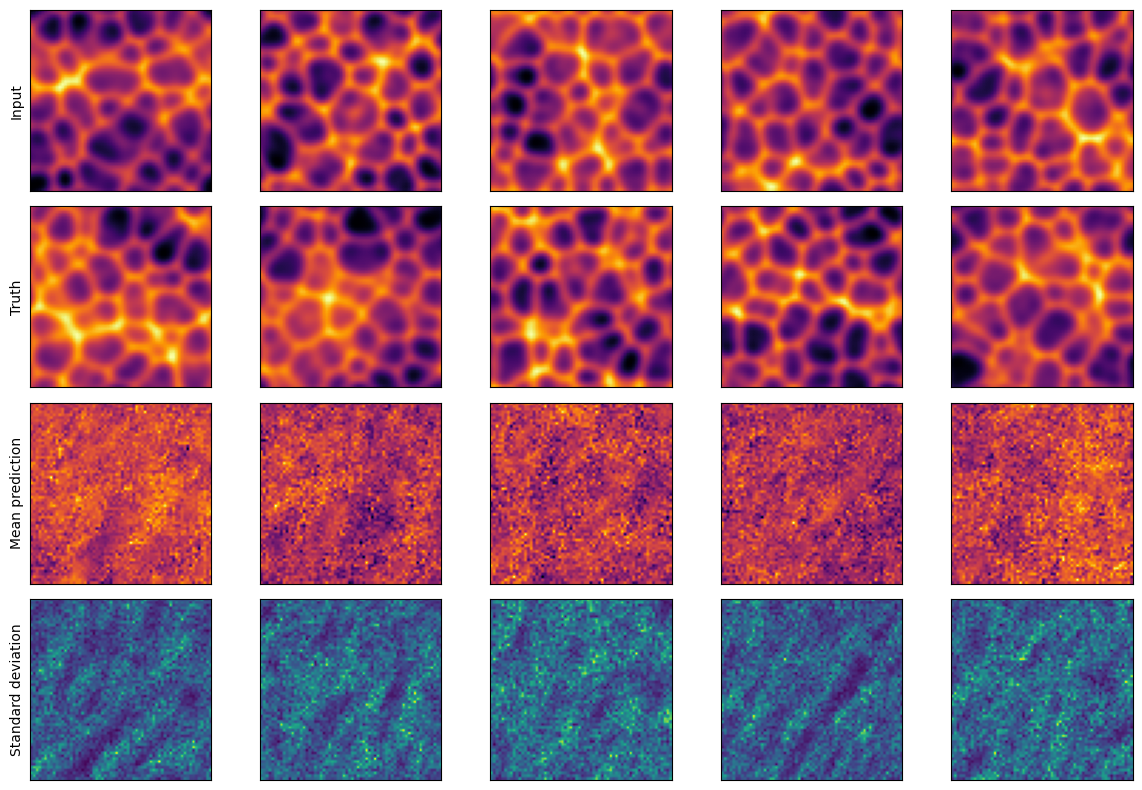

In [34]:
x_test, y_test = test_data
# %%

n_samples = np.random.randint(0,ntest,5)

""" Plotting """ 
fig, axs = plt.subplots(4, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(n_samples):
        axs[0,i].imshow(x_test[sample,0].cpu().numpy(), cmap = "inferno")
        axs[1,i].imshow(y_test[sample,0].cpu().numpy(), cmap = "inferno")
        axs[2,i].imshow(pred[sample,0].cpu().numpy().mean(axis = -1), cmap = "inferno")
        axs[3,i].imshow(pred[sample,0].cpu().numpy().std(axis = -1), cmap = "viridis")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')

fig.tight_layout()

In [35]:
pred[:,0].cpu().numpy().std(axis = -1).mean()

0.7258935

In [36]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.9200541377067566
ES-Dropout: 47.75830841064453
MSE: 1.0851225852966309
ES: 34.02116394042969
